In [1]:
# windows only hack for graphviz path 
import os
for path in os.environ['PATH'].split(os.pathsep):
    if path.endswith("Library\\bin"):
        os.environ['PATH']+=os.pathsep+os.path.join(path, 'graphviz')

In [2]:
from PIL import Image
import numpy as np

In [4]:
import lzma
import pickle
with lzma.open("mnist.pkl.xz", 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

In [5]:
train_X, train_y = train_set
validation_X, validation_y = validation_set
test_X, test_y = test_set

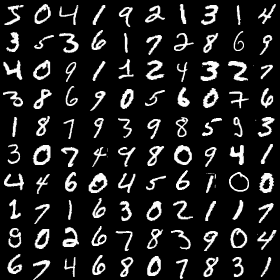

[5 0 4 ... 8 4 8]


In [6]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0] % rows == 0
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*784 -> N*28*28 -> 28*N*28 -> 28 * 28N
    int_X_reshape = int_X.reshape(rows, -1,28,28).swapaxes(1,2).reshape(28*rows,-1)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:100],10)
print(train_y)

## Q
看一下 mnist 資料

## 開始 Tensorflow

In [7]:
import tensorflow as tf
from tfdot import tfdot

## Softmax regression
基本上就是用
$ e ^ {W x +b} $ 的比例來計算機率 

其中 x 是長度 784 的向量（圖片）， W 是 10x784矩陣，加上一個長度為 10 的向量。 算出來的十個數值，依照比例當成我們預估的機率。

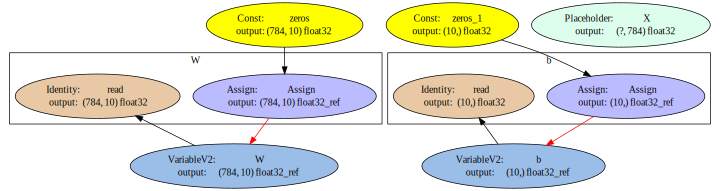

In [8]:
# 輸入的 placeholder
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
# 權重參數，為了計算方便和一些慣例（行向量及列向量的差異），矩陣乘法的方向和上面解說相反
W = tf.Variable(tf.zeros([784, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b') # 這裡可以看成是列向量

tfdot()

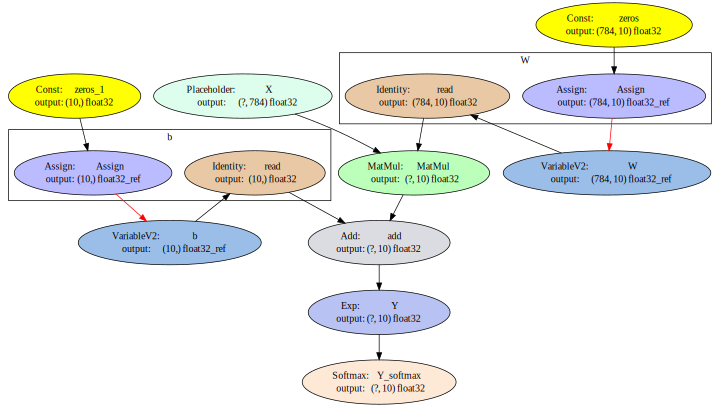

In [9]:
# 計算出來的公式
Y = tf.exp(tf.matmul(X, W) +b, name="Y")
Y_softmax = tf.nn.softmax(Y, name="Y_softmax")
# or 
#Y_softmax = tf.div(Y, tf.reduce_sum(Y, axis=1, keep_dims=True), name="Y_softmax")
tfdot()

Loss function 的計算是 cross_entorpy.

基本上就是 $-log(\Pr(Y_{true}))$

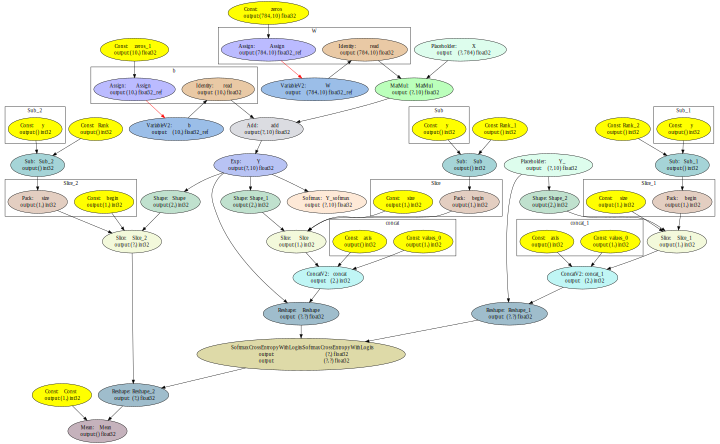

In [10]:
# 真正的 Y
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Y_")
#和算出來的 Y 來做 cross entropy
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_*tf.log(Y_softmax), axis=1))
# or
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
tfdot()

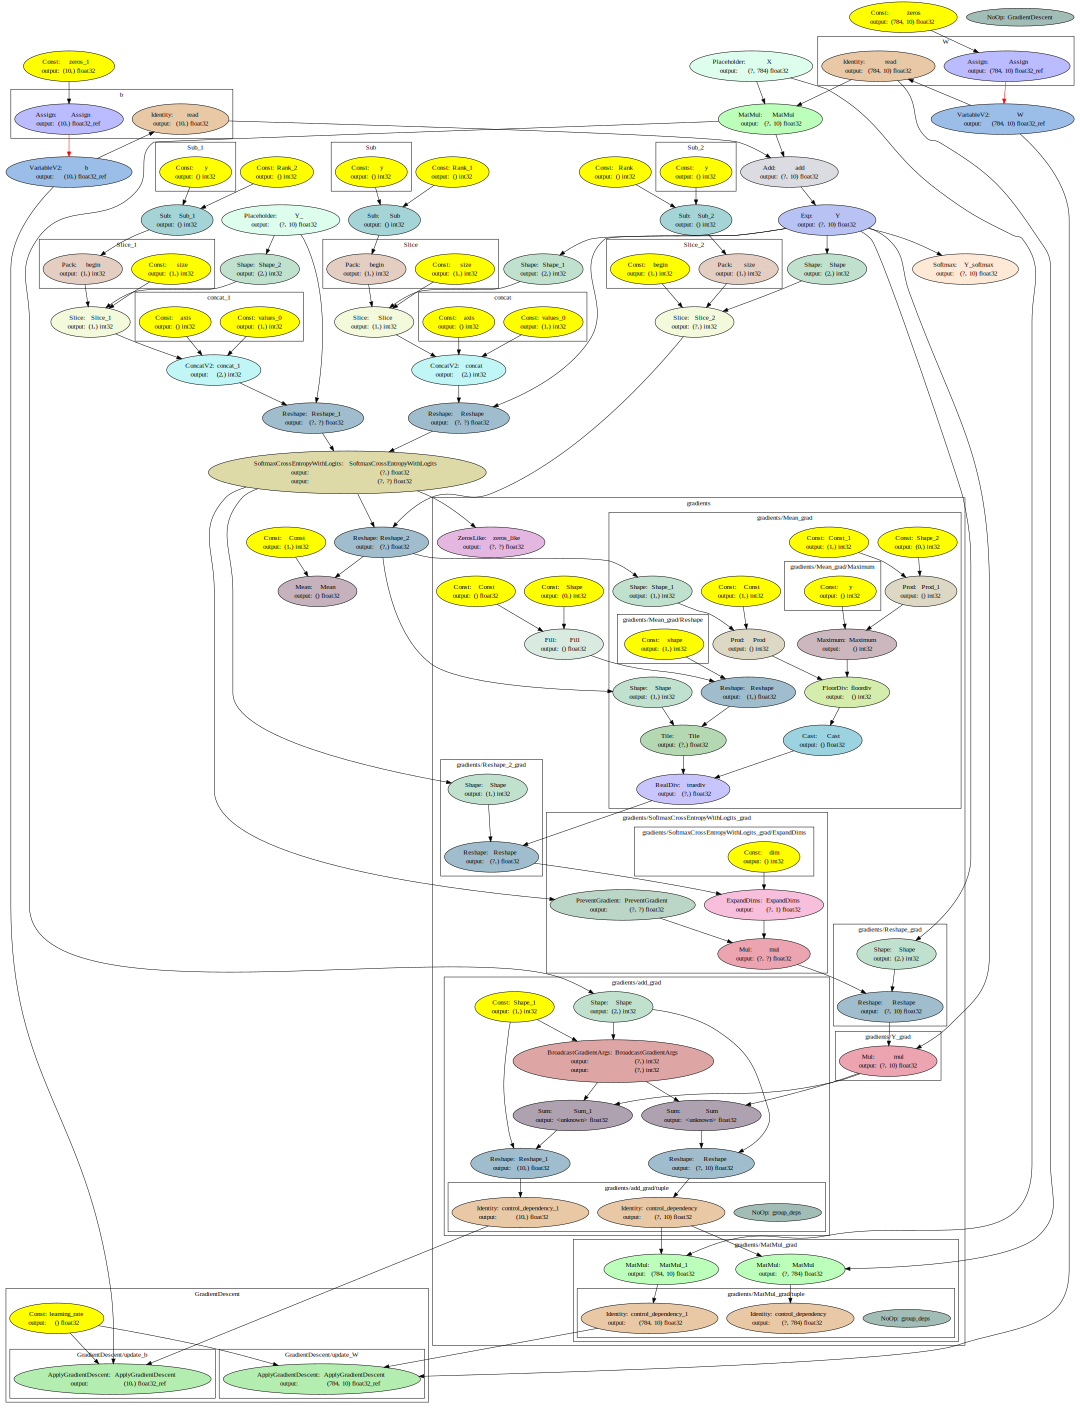

In [11]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

tfdot(size=(15,30))

In [12]:
train_Y = np.eye(10)[train_y]
test_Y = np.eye(10)[test_y]
validation_Y = np.eye(10)[validation_y]

In [13]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [14]:
for i in range(1000):
    rnd_idx = np.random.choice(train_X.shape[0], 50, replace=False)
    train_step.run(feed_dict={X: train_X[rnd_idx], Y_:train_Y[rnd_idx]})

In [15]:
Y.eval(feed_dict={X: train_X[:10]})

array([[ 2.7331278 ,  0.75668585,  2.749466  ,  6.02952   ,  0.6745188 ,
         7.713055  ,  2.0560584 ,  2.880438  ,  2.4291086 ,  1.8765832 ],
       [18.260305  ,  0.27835506,  2.0772495 ,  1.9310365 ,  0.4730624 ,
         3.8643155 ,  1.6390336 ,  2.1759467 ,  2.0709004 ,  0.9705927 ],
       [ 1.031989  ,  0.61700934,  1.8673738 ,  1.9508668 ,  3.8830574 ,
         0.86178505,  1.3318133 ,  1.3456546 ,  1.2979107 ,  1.9232063 ],
       [ 0.9073124 ,  9.428761  ,  3.625791  ,  2.624811  ,  1.2183543 ,
         1.581799  ,  1.4094877 ,  1.5565169 ,  3.5280714 ,  1.4421318 ],
       [ 1.193141  ,  1.6950358 ,  1.2819419 ,  1.6339641 ,  6.981531  ,
         2.3808775 ,  1.6832083 ,  7.7664766 ,  4.016245  , 11.462509  ],
       [ 2.2706356 ,  0.5180408 ,  8.881782  ,  2.475952  ,  1.4552693 ,
         2.2283392 ,  1.403452  ,  2.8703804 ,  2.9483871 ,  4.0985355 ],
       [ 0.35581762, 16.272032  ,  2.9401245 ,  4.794058  ,  1.1418817 ,
         2.176045  ,  1.8736393 ,  1.6175973 

In [16]:
prediction = tf.argmax(Y, axis=1)

# print predictions
prediction.eval(feed_dict={X: train_X[:10]})

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [17]:
# print labels
showX(train_X[:10])
train_y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [18]:
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_, 1))

correct_prediction.eval({X: train_X[:10] , Y_: train_Y[:10]})

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [19]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

accuracy.eval(feed_dict={X: train_X[:10] , Y_: train_Y[:10]})

1.0

In [20]:
accuracy.eval(feed_dict={X: train_X , Y_: train_Y})

0.90824

In [21]:
# 合在一起來看
for t in range(10):
    for i in range(1000):
        rnd_idx = np.random.choice(train_X.shape[0], 200, replace=False)
        train_step.run(feed_dict={X: train_X[rnd_idx], Y_:train_Y[rnd_idx]})
    a = accuracy.eval({X: validation_X , Y_: validation_Y})
    print (t, a)

0 0.9208
1 0.9245
2 0.9273
3 0.9276
4 0.9299
5 0.9307
6 0.9293
7 0.9308
8 0.9303
9 0.93


In [22]:
accuracy.eval({X: test_X , Y_: test_Y})

0.9244

In [23]:
sess.close()

# Multilayer Convolutional Network

In [24]:
# 重設 session 和 graph
tf.reset_default_graph()
# 輸入還是一樣
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Y_")

In [25]:
# 設定 weight 和 bais
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name ='W')
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = 'b')

In [26]:
# 設定 cnn 的 layers
def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

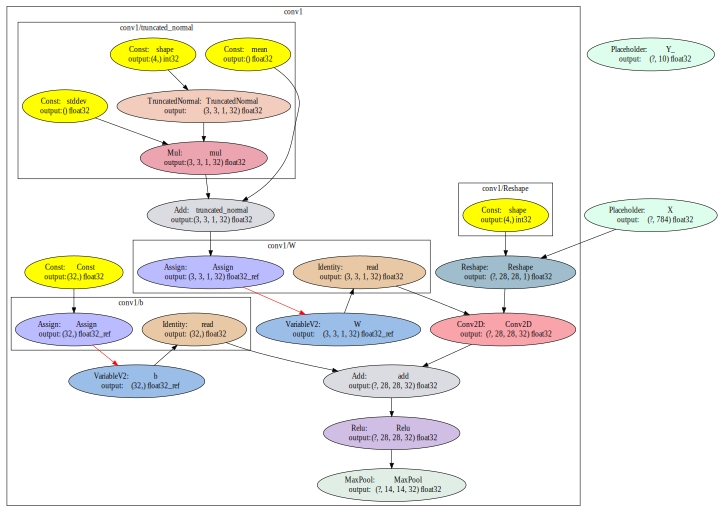

In [27]:
# fisrt layer
with tf.name_scope('conv1'):
    ## variables
    W_conv1 = weight_variable([3,3,1,32])
    b_conv1 = bias_variable([32])
    ## build the layer
    X_image = tf.reshape(X, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(X_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

tfdot()

In [28]:
# second layer
with tf.name_scope('conv2'):
    ## variables
    W_conv2 = weight_variable([3,3,32,64])
    b_conv2 = bias_variable([64])
    ## build the layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

In [29]:
# fully-connected layer
with tf.name_scope('full'):
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1)+b_fc1)

In [30]:
# Dropout:  A Simple Way to Prevent Neural Networks from Over fitting
# https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder("float", name="keep_prob")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout
with tf.name_scope('readout'):
    W_fc2 = weight_variable([1024,10])
    b_fc2 = bias_variable([10])
    Y = tf.matmul(h_fc1_drop, W_fc2)+b_fc2

In [31]:
cross_entropy =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(Y, 1, name="prediction")
correct_prediction = tf.equal(prediction, tf.argmax(Y_, 1), name="correction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [32]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [ ]:
%%timeit -r 1 -n 1
for i in range(5000):
    rnd_idx = np.random.choice(train_X.shape[0], 50, replace=False)
    if i%250 == 0:
        validation_accuracy = accuracy.eval({
                X: validation_X[:200], Y_: validation_Y[:200], keep_prob: 1.0 })
        print("step %d, validation accuracy %g"%(i, validation_accuracy))
    train_step.run({X: train_X[rnd_idx], Y_: train_Y[rnd_idx], keep_prob: 0.5 })

step 0, validation accuracy 0.125


In [ ]:
np.mean([accuracy.eval({X: test_X[i:i+1000], 
                        Y_: test_Y[i:i+1000],
                                   keep_prob: 1.0}) 
        for i in range(0, test_X.shape[0], 1000)]
)

In [ ]:
tf.train.write_graph(sess.graph_def, "./", "mnist_simple.pb", as_text=False)
